# Transfer Learning
Can we use pre-trainined models in Keras to speed up learning?

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [4]:
import os
import glob
import shutil

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import logging

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<IPython.core.display.Javascript object>

Download our cats and dogs data and split them into training and test sets.

In [5]:
_URL = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
zip_dir = tf.keras.utils.get_file(
    "cats_and_dogs_filterted.zip", origin=_URL, extract=True
)
zip_dir_base = os.path.dirname(zip_dir)
base_dir = os.path.join(os.path.dirname(zip_dir), "cats_and_dogs_filtered")
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")

train_cats_dir = os.path.join(
    train_dir, "cats"
)  # directory with our training cat pictures
train_dogs_dir = os.path.join(
    train_dir, "dogs"
)  # directory with our training dog pictures
validation_cats_dir = os.path.join(
    validation_dir, "cats"
)  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(
    validation_dir, "dogs"
)  # directory with our validation dog pictures

num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

<IPython.core.display.Javascript object>

Set up image generators to provide some varied pictures.

In [24]:
BATCH_SIZE = 100
EPOCHS = 6
IMG_SHAPE = 224
class_names = ["Dog", "Cat"]
train_image_generator = ImageDataGenerator(
    rescale=1.0 / 255.0,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode="nearest",
)
val_image_generator = ImageDataGenerator(rescale=1.0 / 255.0)

train_data_gen = train_image_generator.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    class_mode="binary",
)
val_data_gen = val_image_generator.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=validation_dir,
    shuffle=False,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    class_mode="binary",
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


<IPython.core.display.Javascript object>

Reuse mobilenet up to the feature vectors stage, and then learn the last step from those features.

In [ ]:
CLASSIFIER_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

model = tf.keras.Sequential(
    [
        hub.KerasLayer(
            CLASSIFIER_URL, input_shape=(IMG_SHAPE, IMG_SHAPE, 3), trainable=False
        ),
        tf.keras.layers.Dense(len(class_names)),
    ]
)
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
model.summary()

In [14]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=round(total_train / BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=round(total_val / BATCH_SIZE),
)

Epoch 1/6
20/20 [==============================] - 50s 2s/step - loss: 0.4364 - accuracy: 0.7981 - val_loss: 0.1244 - val_accuracy: 0.9650
Epoch 2/6
20/20 [==============================] - 31s 2s/step - loss: 0.1358 - accuracy: 0.9478 - val_loss: 0.1076 - val_accuracy: 0.9580
Epoch 3/6
20/20 [==============================] - 31s 2s/step - loss: 0.0912 - accuracy: 0.9713 - val_loss: 0.0951 - val_accuracy: 0.9650
Epoch 4/6
20/20 [==============================] - 31s 2s/step - loss: 0.0952 - accuracy: 0.9693 - val_loss: 0.0837 - val_accuracy: 0.9660
Epoch 5/6
20/20 [==============================] - 32s 2s/step - loss: 0.0894 - accuracy: 0.9647 - val_loss: 0.0828 - val_accuracy: 0.9730
Epoch 6/6
20/20 [==============================] - 32s 2s/step - loss: 0.0704 - accuracy: 0.9741 - val_loss: 0.0908 - val_accuracy: 0.9700


<IPython.core.display.Javascript object>

We get 97% validation accuracy, which is pretty good. Can we visualise that?
Note that sometimes validation accuracy is better than training accuracy because we're augmenting the training images, but not the validation images.

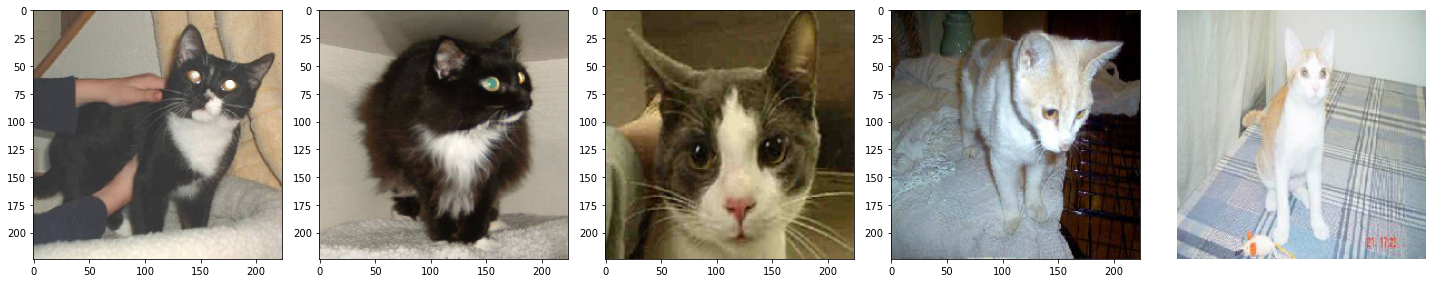

<IPython.core.display.Javascript object>

In [61]:
def plot_images(images_arr, labels=None, real_labels=None):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20, 20))
    axes = axes.flatten()
    for i, (img, ax) in enumerate(zip(images_arr, axes)):
        ax.imshow(img)
        if real_labels is not None and labels is not None:
             color="black" if labels[i] == real_labels[i] else "red"
        else:
            color="black"
        
        if labels is not None:
            ax.set_title(labels[i], color=color)
    ax.axis("off")
    plt.tight_layout()
    plt.show()


image_batch = [val_data_gen[i][0][0] for i in range(5)]
plot_images(image_batch)


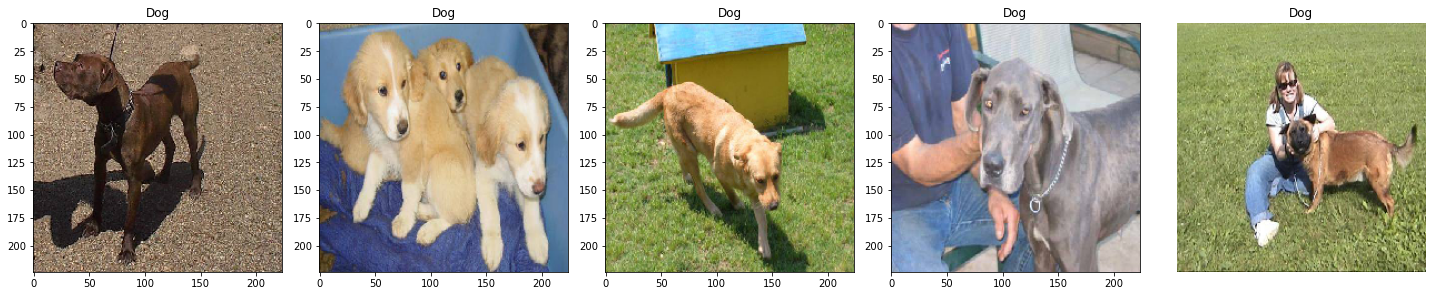

<IPython.core.display.Javascript object>

In [62]:
batch = next(val_data_gen)
predictions = np.argmax(model.predict(batch), axis=1)
predicted_names = np.array(class_names)[predictions]
real_names = np.array(class_names)[batch[1].astype(int)]
plot_images([batch[0][i, :, :, :] for i in range(5)], predicted_names, real_names)

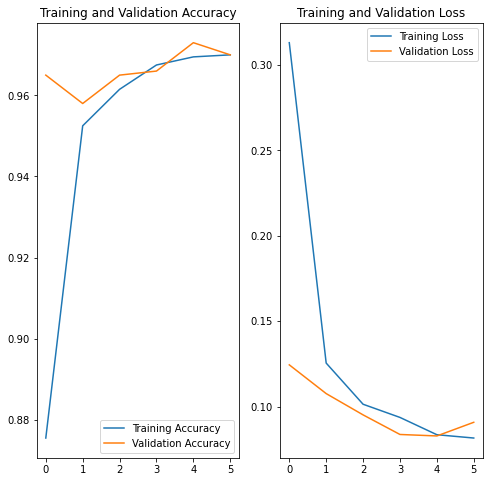

<IPython.core.display.Javascript object>

In [63]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()